# * Installing emoji and demoji

In [1]:
!pip install demoji
!pip install emoji

# * Importing all the required libraries


In [2]:
import nltk
import numpy as np
import os
import keras
import pandas as pd
import matplotlib.pyplot as plt
import re
import emoji
import string as str

# NLTK's
from nltk import word_tokenize
from nltk.classify import SklearnClassifier
from nltk import FreqDist
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import wordnet as wn
from nltk.corpus import stopwords
from collections import Counter
from nltk.stem import WordNetLemmatizer
#from nltk.tag import CRFTagger
#from nltk import pos_tag
#from nltk.stem.porter import PorterStemmer
#tokenizer = nltk.tokenize.TreebankWordTokenizer()
lemmatizer = WordNetLemmatizer()
#demoji.download_codes()
#nltk.download('averaged_perceptron_tagger')

nltk.download('wordnet')
nltk.download('stopwords')

#from collections import defaultdict

# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Flatten, LSTM, Conv1D, MaxPooling1D, Dropout, Activation
from keras.layers.embeddings import Embedding
from keras.layers import Lambda, GlobalAveragePooling1D, Dense, Embedding, Dropout, LSTM
from keras import backend as K

from google.colab import drive
drive.mount('/content/drive')
os.chdir("/content/drive/My Drive/QMUL/NN&NLP/OLIDv1.0")

np.random.seed(500)

Using TensorFlow backend.


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# * Loading the Data

In [0]:
# Load all training and test files for training
trainingdata = pd.read_csv("olid-training-v1.0.tsv", delimiter="\t", encoding='utf-8')

# assiging tweets and subtasks separetely
X_train = trainingdata['tweet']
Y_train_a = trainingdata['subtask_a']
Y_train_b = trainingdata['subtask_b']
Y_train_c = trainingdata['subtask_c']

# Load the Testing Data
testing_data1 = pd.read_csv("testset-levela.tsv", delimiter="\t") 
testing_data2 = pd.read_csv("testset-levelb.tsv", delimiter="\t")  
testing_data3 = pd.read_csv("testset-levelb.tsv", delimiter="\t") 

# * Exploratory Data Analysis

In [4]:
trainingdata.head()

,id,tweet,subtask_a,subtask_b,subtask_c
0,86426,@USER She should ask a few native Americans wh...,OFF,UNT,NaN
1,90194,@USER @USER Go home you’re drunk!!! @USER #MAG...,OFF,TIN,IND
2,16820,Amazon is investigating Chinese employees who ...,NOT,NaN,NaN
3,62688,"@USER Someone should'veTaken"" this piece of sh...",OFF,UNT,NaN
4,43605,@USER @USER Obama wanted liberals &amp; illega...,NOT,NaN,NaN


In [5]:
trainingdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13240 entries, 0 to 13239
Data columns (total 5 columns):
id           13240 non-null int64
tweet        13240 non-null object
subtask_a    13240 non-null object
subtask_b    4400 non-null object
subtask_c    3876 non-null object
dtypes: int64(1), object(4)
memory usage: 517.3+ KB


Offensive:  4400
Not Offensive :  8840


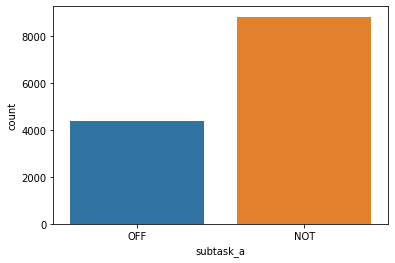

In [6]:
import seaborn as sns
plot_sns = sns.countplot(trainingdata['subtask_a'], label='Total')
NOT, OFF  = trainingdata['subtask_a'].value_counts()
print('Offensive: ',OFF)
print('Not Offensive : ',NOT)

# Preprocessing Dataset

In [0]:
#FACTORIZING LABELS
trainingdata['label']=trainingdata['subtask_a'].factorize()[0]
trainingdata_twt = trainingdata['tweet']
trainingdata_lbl = trainingdata['label']

#FUNTION TO REMOVE 
def remove_PunctuationAndNum(Word):
  # define punctuation
  punctuation = """@:#'’!'!"#$%&()”+,-./:;<=>?@[\\]“^_`{|}~\t\n'"""
  # Space the special characters with white spaces
  output_word = ''
  for char in Word:
    if char not in punctuation and not char.isnumeric():
      output_word = output_word + char
  return output_word


def remove_punct(text):
    text  = "".join([char for char in text if char not in str.punctuation])
    text = re.sub('[0-9]+', '', text)
    return text
ps = nltk.PorterStemmer()

def stemming(text):
    text = [ps.stem(word) for word in text]
    return text

#Dictionary for apostrophe characters
apost_Dict = {
              "'m" :"am", "n't" : "not", "'s" : "is", "'re" : "are", "'ve" : "have", "'ll" : "will", "'d" : "had",
              "cause" : "because", "c'mon" : "come on", "nt" :"not", "'s" : "is", '&' : 'and', '&amp;' : 'and',
              '\+' : 'plus', "'ve" : 'have'
	            }
tokenizer = nltk.tokenize.TreebankWordTokenizer()




#LOWERCASING, REMOVING STOP WORDS, 
def clean_text(tweet):
    stop_words = stopwords.words("english")
    filtered_sentence=[]
    if tweet in apost_Dict:
      tweet = apost_Dict[tweet]
    tweet = emoji.demojize(tweet)
    tweet = remove_PunctuationAndNum(tweet)
    tweet = tweet.lower().split()
    filtered_sentence = [w for w in tweet if w not in stop_words]
    filtered_sentence = " ".join(filtered_sentence)
    return filtered_sentence


X_train_preprocessed = trainingdata['tweet'].map(lambda x: clean_text(x))
#print(trainingdata)
#X_train_preprocessed = trainingdata['tweet']
# count0 = 0
# count1 = 0
# for i in trainingdata["label"]:
#     if i == 0:
#         count0+=1
#     else:
#         count1+=1
# print("Offensive Tweets: ",count0)
# print("Non Offensive Tweets: ",count1)

In [8]:
X_train_preprocessed

0                           user ask native americans take
1        user user go home youre drunk user maga trump ...
2        amazon investigating chinese employees selling...
3        user someone shouldvetaken piece shit volcano ...
4        user user obama wanted liberals amp illegals m...
                               ...                        
13235    user sometimes get strong vibes people mans vi...
13236    benidorm whiteheavycheckmark creamfields white...
13237                   user report garbage dont give crap
13238                                           user pussy
13239    spanishrevenge vs justice humanrights freedomo...
Name: tweet, Length: 13240, dtype: object

* TOKENIZING AND CREATING SEQUENCE

In [9]:
#TOKENIZING AND CREATING SEQUENCE 1
tokenizer = keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(X_train_preprocessed)

word2idx = tokenizer.word_index
word2idx = {k:(v+2) for k,v in word2idx.items()}
word2idx["<PAD>"] = 0
word2idx["<START>"] = 1
word2idx["<UNK>"] = 2
print(word2idx)
#print(trainingdata['tweet'])

{'user': 3, 'url': 4, 'liberals': 5, 'gun': 6, 'control': 7, 'antifa': 8, 'like': 9, 'maga': 10, 'conservatives': 11, 'dont': 12, 'people': 13, 'get': 14, 'amp': 15, 'one': 16, 'know': 17, 'trump': 18, 'think': 19, 'would': 20, 'im': 21, 'good': 22, 'right': 23, 'us': 24, 'thats': 25, 'time': 26, 'want': 27, 'go': 28, 'need': 29, 'see': 30, 'never': 31, 'going': 32, 'shit': 33, 'even': 34, 'say': 35, 'love': 36, 'cant': 37, 'make': 38, 'really': 39, 'way': 40, 'back': 41, 'still': 42, 'much': 43, 'well': 44, 'left': 45, 'vote': 46, 'doesnt': 47, 'democrats': 48, 'better': 49, 'also': 50, 'take': 51, 'believe': 52, 'hes': 53, 'party': 54, 'man': 55, 'youre': 56, 'said': 57, 'president': 58, 'u': 59, 'country': 60, 'many': 61, 'great': 62, 'didnt': 63, 'look': 64, 'keep': 65, 'hope': 66, 'nothing': 67, 'liberal': 68, 'could': 69, 'another': 70, 'years': 71, 'kavanaugh': 72, 'stop': 73, 'thing': 74, 'lol': 75, 'please': 76, 'trying': 77, 'always': 78, 'sure': 79, 'laws': 80, 'got': 81, 's

# * Preparing input data

In [10]:
vocabulary_size = len(word2idx.items())
max_len = 200

# to view a padded review:
sequences = tokenizer.texts_to_sequences(X_train_preprocessed)
X_train_preprocessed_final = pad_sequences(sequences, maxlen=max_len)
print(X_train_preprocessed_final)
y = np.array(trainingdata['label'])

Y_train_a = trainingdata['label']
print(Y_train_a)
Label_ENC_dict={
    'OFF' : 1,
    'NOT' : 0
}

[[    0     0     0 ...  2473   191    49]
 [    0     0     0 ...    16  8891     2]
 [    0     0     0 ...   239   736   403]
 ...
 [    0     0     0 ...    10    97   496]
 [    0     0     0 ...     0     1   937]
 [    0     0     0 ... 21121     1     2]]
0        0
1        0
2        1
3        0
4        1
        ..
13235    0
13236    1
13237    0
13238    0
13239    1
Name: label, Length: 13240, dtype: int64


# * Model

In [11]:
VOCAB_SIZE = len(word2idx)
EMBED_SIZE = 100

model = Sequential()
model.add(Embedding(input_dim=VOCAB_SIZE,output_dim=EMBED_SIZE,input_length=max_len,name ='Embedding_layer' ))
model.add(Dropout(rate = 0.2, noise_shape=None, seed=None))
model.add(LSTM(units = 100,activation='tanh',name ='LSTM_layer'))
model.add(Dropout(rate = 0.2, noise_shape=None, seed=None))
model.add(Dense(units =1, activation='sigmoid',name ='Output_layer'))
model.summary()

model.compile( loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Embedding_layer (Embedding)  (None, 200, 100)          2112400   
_________________________________________________________________
dropout_1 (Dropout)          (None, 200, 100)          0         
_________________________________________________________________
LSTM_layer (LSTM)            (None, 100)               80400     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
Output_layer (Dense)         (None, 1)                 101       
Total params: 2,192,901
Trainable params: 2,192,901
Non-trainable params: 0
_________________________________________________________

**# Train Validation split**

In [0]:
X_val = X_train_preprocessed_final[:3000]
partial_X_train = X_train_preprocessed_final[3000:]

y_val_a = np.array(Y_train_a[:3000])
partial_y_train_a = np.array(Y_train_a[3000:])

**# Training**

In [13]:
history = model.fit(partial_X_train,
                    partial_y_train_a,
                    epochs=3,
                    batch_size=100,
                    validation_data=(X_val, y_val_a),
                    verbose=1)




Train on 10240 samples, validate on 3000 samples
Epoch 1/3





10240/10240 [==============================] - 59s 6ms/step - loss: 0.6086 - acc: 0.6780 - val_loss: 0.5648 - val_acc: 0.7117
Epoch 2/3
10240/10240 [==============================] - 58s 6ms/step - loss: 0.4131 - acc: 0.8161 - val_loss: 0.5631 - val_acc: 0.7500
Epoch 3/3
10240/10240 [==============================] - 58s 6ms/step - loss: 0.2434 - acc: 0.9037 - val_loss: 0.6721 - val_acc: 0.7243


In [14]:
# Load the Testing Data
testing_data_lvl_a = pd.read_csv("testset-levela.tsv", delimiter="\t",encoding='utf-8',names=['ID','tweets']) 
# Load levels
levels_a = pd.read_csv('labels-levela.csv',delimiter=',',encoding='utf-8', names=['ID','labels'])

X_test_a = testing_data_lvl_a['tweets']
Y_test_a = levels_a['labels']
X_test_a = X_test_a.drop(0)
#print(X_test_a)
print(Y_test_a)
#print(len(word2idx))

0      OFF
1      NOT
2      NOT
3      NOT
4      OFF
      ... 
855    OFF
856    NOT
857    OFF
858    NOT
859    NOT
Name: labels, Length: 860, dtype: object


In [15]:
  X_test_preprocessed_a = X_test_a.map(lambda x: clean_text(x))

  print(X_test_preprocessed_a)

1      whoisq wherestheserver dumpnike declasfisa dem...
2      constitutionday revered conservatives hated pr...
3      foxnews nra maga potus trump ndamendment rnc u...
4      watching boomer getting news still parole alwa...
5      nopasaran unity demo oppose farright london – ...
                             ...                        
856    despicabledems lie rifles dem distorted law pu...
857    meetthespeakers raisinghands user present even...
858    people unfollowed talking merlin sorry yall im...
859    wednesdaywisdom antifa calls right fascist rea...
860             kavanaugh typical liberals democrats url
Name: tweets, Length: 860, dtype: object


In [16]:
tokenizer = keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(X_test_preprocessed_a)

word2idx = tokenizer.word_index
word2idx = {k:(v+2) for k,v in word2idx.items()}
word2idx["<PAD>"] = 0
word2idx["<START>"] = 1
word2idx["<UNK>"] = 2
print(word2idx)

Y_test_a_ENC = []

for value in Y_test_a:
  #print(value)
  Y_test_a_ENC.append(Label_ENC_dict[value])

sequences = tokenizer.texts_to_sequences(X_test_preprocessed_a) #[1:]
X_test_preprocessed_final = pad_sequences(sequences, maxlen=max_len)


{'user': 3, 'url': 4, 'liberals': 5, 'conservatives': 6, 'antifa': 7, 'like': 8, 'gun': 9, 'control': 10, 'dont': 11, 'maga': 12, 'get': 13, 'one': 14, 'us': 15, 'people': 16, 'trump': 17, 'im': 18, 'want': 19, 'love': 20, 'via': 21, 'good': 22, 'know': 23, 'going': 24, 'new': 25, 'see': 26, 'democrats': 27, 'never': 28, 'need': 29, 'please': 30, 'way': 31, 'kavanaugh': 32, 'support': 33, 'time': 34, 'shit': 35, 'always': 36, 'still': 37, 'think': 38, 'years': 39, 'really': 40, 'go': 41, 'life': 42, 'cant': 43, 'even': 44, 'keep': 45, 'qanon': 46, 'back': 47, 'says': 48, 'say': 49, 'ever': 50, 'right': 51, 'help': 52, 'chicago': 53, 'believe': 54, 'day': 55, 'thats': 56, 'make': 57, 'look': 58, 'left': 59, 'much': 60, 'nothing': 61, 'hope': 62, 'well': 63, 'best': 64, 'america': 65, 'death': 66, 'stop': 67, 'law': 68, 'take': 69, 'great': 70, 'first': 71, 'party': 72, 'gop': 73, 'work': 74, 'walkaway': 75, 'said': 76, 'matter': 77, 'news': 78, 'lets': 79, 'would': 80, 'looking': 81, 'f

In [17]:
results_a = model.evaluate(X_test_preprocessed_final, Y_test_a_ENC) 
print(results_a)

860/860 [==============================] - 2s 2ms/step
[1.9514852540437566, 0.3744186046511628]


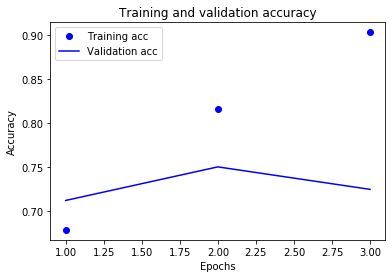

In [18]:
import matplotlib.pyplot as plt

history_dict = history.history

acc = history_dict['acc']
val_acc = history_dict['val_acc']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

**# Part A B C**

**Multi class training data preparartion**

In [19]:
Y_train_M = Y_train_a.copy()



for i, label in enumerate(Y_train_a):
  if label == 'OFF':
    Y_train_M[i] = Y_train_M[i] +"-"+ Y_train_b[i]
    if Y_train_b[i] == 'TIN':
      Y_train_M[i] = Y_train_M[i] +"-"+ Y_train_c[i]

#print(Y_train_M.unique())    

# One Hot encoding the labels
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(Y_train_M)

onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_train_Y = onehot_encoder.fit_transform(integer_encoded)

print(onehot_train_Y)

# Train val split

y_val_M = np.array(onehot_train_Y[:3000])
partial_y_train_M = np.array(onehot_train_Y[3000:])

[[1. 0.]
 [1. 0.]
 [0. 1.]
 ...
 [1. 0.]
 [1. 0.]
 [0. 1.]]


**Multiclass Classifier Model**

In [20]:
model2 = Sequential()
model2.add(Embedding(input_dim=VOCAB_SIZE,output_dim=EMBED_SIZE,input_length=max_len,name ='Embedding_layer' ))
model2.add(Dropout(rate = 0.5, noise_shape=None, seed=None))
model2.add(LSTM(units = 100,activation='tanh',name ='LSTM_layer'))
model2.add(Dropout(rate = 0.5, noise_shape=None, seed=None))
model2.add(Dense(units =5, activation='softmax',name ='Output_layer'))
model2.summary()

model2.compile(
              loss='categorical_crossentropy',optimizer='adam',
              metrics=['accuracy'])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Embedding_layer (Embedding)  (None, 200, 100)          2112400   
_________________________________________________________________
dropout_3 (Dropout)          (None, 200, 100)          0         
_________________________________________________________________
LSTM_layer (LSTM)            (None, 100)               80400     
_________________________________________________________________
dropout_4 (Dropout)          (None, 100)               0         
_________________________________________________________________
Output_layer (Dense)         (None, 5)                 505       
Total params: 2,193,305
Trainable params: 2,193,305
Non-trainable params: 0
_________________________________________________________________


**Training**

In [21]:
history2 = model2.fit(partial_X_train,
                    partial_y_train_M,
                    epochs=3,
                    batch_size=100,
                    validation_data=(X_val, y_val_M),
                    verbose=1)

ValueError: ignored

**Test Data**

In [22]:
Y_test_df_b = pd.read_csv('labels-levelb.csv',delimiter=',',encoding='utf-8', names=['ID','labels'])
Y_test_df_c = pd.read_csv('labels-levelc.csv',delimiter=',',encoding='utf-8', names=['ID','labels'])

j = 0
k = 0
Y_test_M = Y_test_a.copy()
# print(Y_test_df_b['ID'])
# print((Y_test_df_b['ID'][0] == Y_test_df_b['ID'][0]))
for i,ids in enumerate(levels_a['ID']):
  #print(ids)
  if ids in Y_test_df_b.values:
    
    Y_test_M[i] = Y_test_M[i] +"-"+ Y_test_df_b['labels'][j]
    j += 1

    if ids in Y_test_df_c.values:
      Y_test_M[i] = Y_test_M[i] +"-"+ Y_test_df_c['labels'][k]
      k += 1
print(Y_test_M) 


integer_encoded = label_encoder.fit_transform(Y_test_M)


integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_test_Y = onehot_encoder.fit_transform(integer_encoded)

print(onehot_test_Y)

0      OFF-TIN-OTH
1              NOT
2              NOT
3              NOT
4      OFF-TIN-GRP
          ...     
855    OFF-TIN-GRP
856            NOT
857        OFF-UNT
858            NOT
859            NOT
Name: labels, Length: 860, dtype: object
[[0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 ...
 [0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]]


In [23]:
results_M = model2.evaluate(X_test_preprocessed_final, onehot_test_Y) 
print(results_M)

860/860 [==============================] - 2s 2ms/step
[1.6116877877435019, 0.14069767462652782]


**Trying CNN model**

In [24]:
from keras.layers import Lambda, GlobalAveragePooling1D, GlobalMaxPooling1D,Dense, Embedding, Dropout, LSTM,Conv1D

model3 = Sequential()
model3.add(Embedding(input_dim=VOCAB_SIZE,output_dim=EMBED_SIZE,input_length=max_len,name ='Embedding_layer' ))
model3.add(Conv1D(128, kernel_size=5, activation='relu'))
model3.add(GlobalMaxPooling1D())
model3.add(Dense(10, activation='relu'))
model3.add(Dense(5, activation='sigmoid'))
model3.summary()

model3.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Embedding_layer (Embedding)  (None, 200, 100)          2112400   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 196, 128)          64128     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1290      
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 55        
Total params: 2,177,873
Trainable params: 2,177,873
Non-trainable params: 0
_________________________________________________________________


In [25]:
history3 = model3.fit(partial_X_train,
                    partial_y_train_M,
                    epochs=3,
                    batch_size=100,
                    validation_data=(X_val, y_val_M),
                    verbose=1)

ValueError: ignored

In [26]:
results_M_CNN = model3.evaluate(X_test_preprocessed_final, onehot_test_Y) 
print(results_M_CNN)

860/860 [==============================] - 1s 903us/step
[1.6046160376349161, 0.697674419159113]


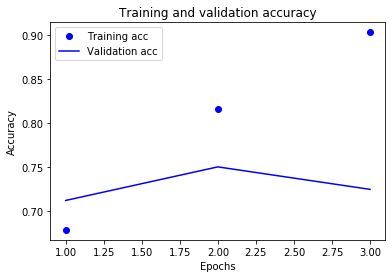

In [27]:
import matplotlib.pyplot as plt

history_dict = history.history

acc = history_dict['acc']
val_acc = history_dict['val_acc']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()